In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
try:
    historical_df = pd.read_csv('historical_data.csv')
    fgi_df = pd.read_csv('fear_greed_index.csv')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Could not find 'historical_data.csv' or 'fear_greed_index.csv'.")
    raise

Data loaded successfully.


In [4]:
# Converting key performance columns to numeric (also handling potential errors with 'coerce')
historical_df['Closed PnL'] = pd.to_numeric(historical_df['Closed PnL'], errors='coerce').fillna(0)
historical_df['Size USD'] = pd.to_numeric(historical_df['Size USD'], errors='coerce').fillna(0)
historical_df['Fee'] = pd.to_numeric(historical_df['Fee'], errors='coerce').fillna(0)

In [5]:
historical_df['Trade_Date'] = pd.to_datetime(historical_df['Timestamp IST'], format='%d-%m-%Y %H:%M').dt.date
# Convert the FGI date column to match the format of the historical data date
fgi_df['Date'] = pd.to_datetime(fgi_df['date']).dt.date
fgi_df['FGI_Value'] = pd.to_numeric(fgi_df['value'], errors='coerce')

In [6]:
# Group the historical trades by day to get daily performance metrics
daily_performance_df = historical_df.groupby('Trade_Date').agg(
    Daily_PnL=('Closed PnL', 'sum'),
    Daily_Volume_USD=('Size USD', 'sum'),
    Daily_Net_Fee=('Fee', 'sum'),
    Total_Trades=('Trade ID', 'count')
).reset_index()

In [7]:
# Join the daily trading performance with the corresponding Fear Greed Index data
merged_df = daily_performance_df.merge(
    fgi_df[['Date', 'FGI_Value', 'classification']],
    left_on='Trade_Date',
    right_on='Date',
    how='inner'
).drop(columns=['Date'])

In [8]:
# Let's see some merged data for confirmation 
print("\n Merged Daily Data Head ")
print(merged_df.head())


 Merged Daily Data Head 
   Trade_Date   Daily_PnL  Daily_Volume_USD  Daily_Net_Fee  Total_Trades  \
0  2023-05-01    0.000000            477.00       0.000000             3   
1  2023-12-05    0.000000          50005.83      12.501455             9   
2  2023-12-14 -205.434737         113203.35      28.300831            11   
3  2023-12-15  -24.632034          10609.95       2.652489             2   
4  2023-12-16    0.000000          15348.77       3.837189             3   

   FGI_Value classification  
0         63          Greed  
1         75  Extreme Greed  
2         72          Greed  
3         70          Greed  
4         67          Greed  


In [9]:
# Create cumulative and more granular sentiment zones based on Fear Greed Index numerical values
bins = [0, 20, 40, 60, 80, 100]
labels = ['Extreme Fear (0-20)', 'Fear (21-40)', 'Neutral (41-60)', 'Greed (61-80)', 'Extreme Greed (81-100)']
merged_df['FGI_Zone'] = pd.cut(merged_df['FGI_Value'], bins=bins, labels=labels, right=True, include_lowest=True)

In [12]:
# Now I am aggregating by FGI Zone ---
fgi_zone_summary = merged_df.groupby('FGI_Zone', observed=True).agg(
    Avg_PnL=('Daily_PnL', 'mean'),
    Avg_Volume=('Daily_Volume_USD', 'mean'),
    # Use 'transform' or a lambda function that works with observed=True for win rate
    Win_Rate=('Daily_PnL', lambda x: (x > 0).sum() / x.count()),
    Total_Days=('Trade_Date', 'count')
).reset_index()

In [13]:
# Let's summarize the zone datas
fgi_zone_summary['Avg_PnL_per_Volume'] = fgi_zone_summary['Avg_PnL'] / fgi_zone_summary['Avg_Volume']
fgi_zone_summary = fgi_zone_summary.sort_values(by='Avg_PnL', ascending=False)
print("\n--- Deeper FGI Zone Performance Analysis ---")
print(fgi_zone_summary)


--- Deeper FGI Zone Performance Analysis ---
                 FGI_Zone       Avg_PnL    Avg_Volume  Win_Rate  Total_Days  \
0     Extreme Fear (0-20)  76048.889562  8.016851e+06  0.666667           9   
4  Extreme Greed (81-100)  42635.853290  1.198180e+06  0.941176          34   
2         Neutral (41-60)  28579.457758  3.672594e+06  0.693069         101   
1            Fear (21-40)  27377.102921  5.059758e+06  0.729412          85   
3           Greed (61-80)  11627.395798  1.108790e+06  0.764000         250   

   Avg_PnL_per_Volume  
0            0.009486  
4            0.035584  
2            0.007782  
1            0.005411  
3            0.010487  


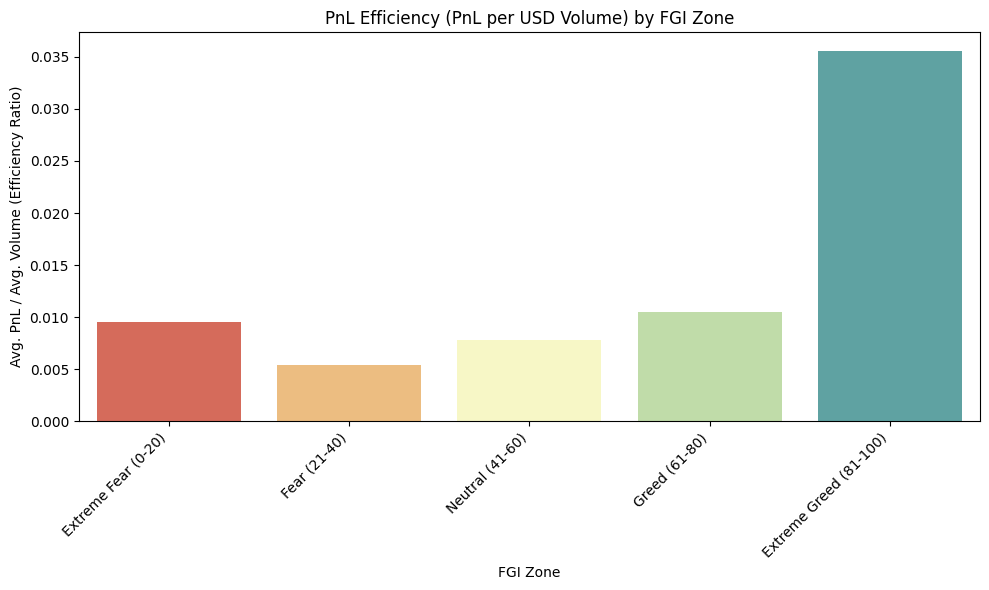

In [15]:
# Visualization of PnL vs. Volume Efficiency for taking zone based descision
plt.figure(figsize=(10, 6))
sns.barplot(
    x='FGI_Zone',
    y='Avg_PnL_per_Volume',
    data=fgi_zone_summary,
    hue='FGI_Zone',  # Added to silence the warning
    legend=False,   # Added to silence the warning
    palette='Spectral'
)
plt.title('PnL Efficiency (PnL per USD Volume) by FGI Zone')
plt.xlabel('FGI Zone')
plt.ylabel('Avg. PnL / Avg. Volume (Efficiency Ratio)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [18]:
# Let's do some Sentiment and Directional Bias Analysis 
fgi_analysis_df = fgi_df[['Date', 'classification']].copy()

In [19]:
# This new DataFrame retains individual trade details like 'Side' and 'Closed PnL'.
trade_level_merged_df = historical_df.merge(
    fgi_analysis_df,
    left_on='Trade_Date',
    right_on='Date',
    how='inner'
).drop(columns=['Date'])

In [20]:
#Let's check the new data
print("--- Successfully created Trade-Level Merged Data ---")
print(trade_level_merged_df[['Trade_Date', 'Side', 'Closed PnL', 'classification']].head())

--- Successfully created Trade-Level Merged Data ---
   Trade_Date Side  Closed PnL classification
0  2024-12-02  BUY         0.0  Extreme Greed
1  2024-12-02  BUY         0.0  Extreme Greed
2  2024-12-02  BUY         0.0  Extreme Greed
3  2024-12-02  BUY         0.0  Extreme Greed
4  2024-12-02  BUY         0.0  Extreme Greed


In [21]:
directional_analysis = trade_level_merged_df.groupby(['classification', 'Side']).agg(
    Total_PnL=('Closed PnL', 'sum'),
    Avg_Execution_Price=('Execution Price', 'mean'),
    Trade_Count=('Trade ID', 'count')
).reset_index()

In [22]:
# Calculate Average PnL per Trade
directional_analysis['Avg_PnL_per_Trade'] = directional_analysis['Total_PnL'] / directional_analysis['Trade_Count']
directional_analysis = directional_analysis.sort_values(by=['classification', 'Avg_PnL_per_Trade'], ascending=[True, False])
# Also Display it
print("\n--- Sentiment and Directional Bias Results ---")
print(directional_analysis)


--- Sentiment and Directional Bias Results ---
  classification  Side     Total_PnL  Avg_Execution_Price  Trade_Count  \
1   Extreme Fear  SELL  3.660668e+05          6949.339877        10465   
0   Extreme Fear   BUY  3.730434e+05          7155.717741        10935   
3  Extreme Greed  SELL  2.526821e+06          4728.426601        22052   
2  Extreme Greed   BUY  1.883508e+05          7746.260514        17940   
4           Fear   BUY  1.935073e+06         14734.476885        30270   
5           Fear  SELL  1.422082e+06         13594.670426        31567   
7          Greed  SELL  1.535673e+06         10319.784597        25727   
6          Greed   BUY  6.144566e+05         16647.555974        24576   
9        Neutral  SELL  7.385056e+05         10084.102482        18717   
8        Neutral   BUY  5.544151e+05         14672.600553        18969   

   Avg_PnL_per_Trade  
1          34.980106  
0          34.114627  
3         114.584643  
2          10.498927  
4          63.927104  

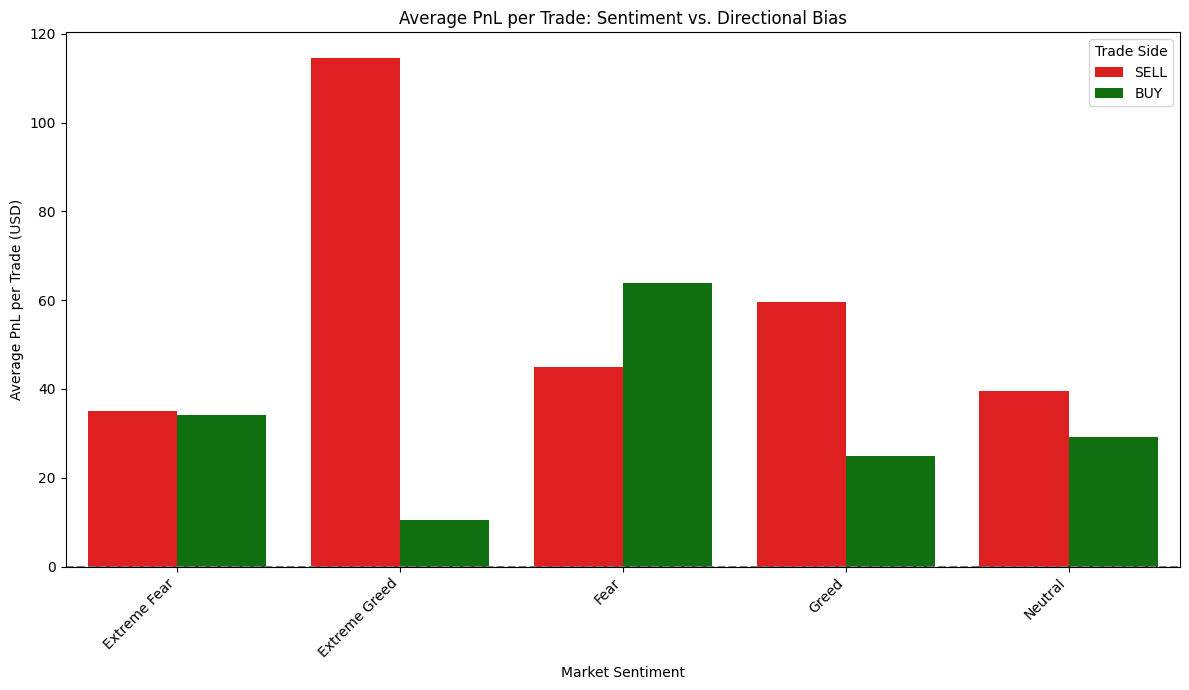

In [23]:
# Lets Visualize it
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7))
sns.barplot(
    x='classification',
    y='Avg_PnL_per_Trade',
    hue='Side',
    data=directional_analysis,
    palette={'BUY': 'green', 'SELL': 'red'}
)
plt.title('Average PnL per Trade: Sentiment vs. Directional Bias')
plt.xlabel('Market Sentiment')
plt.ylabel('Average PnL per Trade (USD)')
plt.xticks(rotation=45, ha='right')
plt.axhline(0, color='gray', linestyle='--')
plt.legend(title='Trade Side')
plt.tight_layout()
plt.show()